In [4]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# If you are working in Colab, then consider mounting folder to your drive
from google.colab import drive
drive.mount('/content/drive')

# Direct to your folder.
%cd /content/drive/MyDrive/computer_vision/diffusion_models/

In [5]:
import torch
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat the single channel three times
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize all three channels
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

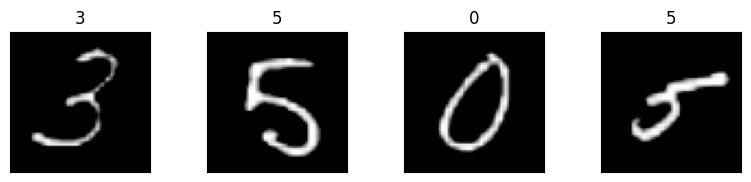

In [7]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.numpy()

images = np.transpose(images, (0, 2, 3, 1))
images = np.clip(images, 0, 1)

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(4):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx])
    ax.set_title(str(labels[idx].item()))

plt.show()

In [8]:
from ddpm import Diffusion, Trainer, UNet
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet(in_channels=3, out_channels=3, timestep_dim=2, device=device)
diffusion = Diffusion(noise_steps=16, beta_start=1e-4, beta_end=0.02, img_size=next(iter(trainloader))[0].shape[-1], device=device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3)

trainer = Trainer(model=unet, 
                  diffusion=diffusion, 
                  optimizer=optimizer, 
                  criterion=criterion, 
                  trainloader=trainloader, 
                  save_path='mnist_ddpm.pth',
                  device=device)

In [ ]:
trainer.train_model(epochs=1)